We are creating a dataset which is based on all of the dual-task trials per block and we are ignoring the practice trials
The dataset is built by merging the results acquired in the paper created by Chris.

Some columns are based on the significance provided in the said paper ( & maybe image here)
The csv files we are merging into our dataset are provided below

- MaxDeviationPerTrial.csv
- maxnrDigitEnteredPerPPAndPerBlockPerTrial.csv
- numberOfVisitsTrackerPerParticipantPerBlock.csv (trial data)
- samplesOutsideTrial.csv(*)
- sdVisTime.csv(*)
- tableForMeanTimeInDigitPerPPandPerBlock.csv(*) - merge the data ber block maybe?
- We are using the payoff function values provided in the meanVisTime.csv file
- The columns marked with star could be significant and we are testing to see the results with or without the said feature

## 0. Load the data

In [1]:
# We first read the data and display it
final_rows = []

output_dist = 'distance'
output_pred = 'prediction'

import pandas as pd
data = pd.read_csv('./data.csv');

print(data.shape)

display('Loaded the data!')

(1920, 14)


'Loaded the data!'

## 1. Split the data into 8 data sets
We first split the data into 8 datasets and we calculate the mean value for each of the datasetin order to see how biased the data is in terms of Radius, Noise and the payoff function

In [2]:
split_on = ['PayOffFunction','Radius','Noise']

def split(dataSets,col):
    
    s = []
    
    for data in dataSets:
        
        if(col >= len(split_on)):
            return None
        
        values = {}
        
        for row in range(0,data.shape[ 0 ]):
            splitColumn = split_on[ col ]

            rowValue = data.iloc[ row ][ splitColumn ]
            
            if not rowValue in values:
                values[ rowValue ] = [ ]
                
            values[ rowValue ].append(row)
            
        for value in values:
            nextSet = []
            
            for row in values[value]:
                nextSet.append(data.iloc[ row ])
                
            s.append(pd.DataFrame(nextSet))
    res = split( s , col + 1 )
    
    if res is None:
        return s
    else: 
        return res
    
sets = [ data ]

split_sets = split(sets,0)

#for debug
#i = 0
#for item in split_sets:
#    item.to_csv('dataset_' + str(i) + '.csv')
#    i = i + 1

print('resulting length : ' +  str(len(split_sets)))


resulting length : 8


In [3]:

#We then take the top N percent of each of the sets

def get_by_split(sets,start, step, end, func):
    
    while start <= end:
    
        for dataSet in sets:
            func(start,dataSet)
            
        start = start + step

per_tick = {}

#we save all of the datasets in this variable for later use
datasets = []

#We then compute the mean for the score column for the provided dataset
def mean(current_tick,item):

    #meanVal = item['Score'].mean()
    
    #if current_tick not in per_tick:
    #    per_tick[current_tick]= []
   #     
   # per_tick[current_tick].append(meanVal)
    datasets.append(item)

get_by_split(split_sets, 1, 0.05, 1,mean)

In [4]:
from sklearn.utils import shuffle
d = []
for dataset in datasets:
    newset = shuffle(dataset)
    d.append(newset)
datasets = d

## 2. For each of the produced datasets we can now compute different statististics.
Currently we are computing and plotting the mean value.

In [5]:
# We can now measure the distributions
# by testing different sizes

import matplotlib.pyplot as plt
import numpy as np

for tick_size in per_tick:
    tick_marks = np.arange(len(per_tick[tick_size]))
    fig, ax = plt.subplots()
    plt.bar(tick_marks,per_tick[tick_size])
    plt.show()

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
dictionary = {}

i = 0;
perc = 10
rowCounter = 0

print( 'there are ' + str(len(datasets)) + ' datasets' )

while(i <= 9):
    
    print('starting to aquire chunk ' + str(i))
    
    rp = []

    for next_set in datasets:
        size = int(next_set.shape[0] / perc)
        
        #starting point
        take = i * size
        start = take
        end = take + size
        next_items = next_set[start:end]
        
        frame = pd.DataFrame(next_items,columns=next_set.columns)
        rp.append(frame)
        
    dictionary[ i ] = pd.concat(shuffle(rp))
    
    i = i + 1
    
print('done partitioning in chunks')

there are 8 datasets
starting to aquire chunk 0
starting to aquire chunk 1
starting to aquire chunk 2
starting to aquire chunk 3
starting to aquire chunk 4
starting to aquire chunk 5
starting to aquire chunk 6
starting to aquire chunk 7
starting to aquire chunk 8
starting to aquire chunk 9
done partitioning in chunks


## 3. Then we split the data by using cross-sampling and we use cross-validation

The idea behind this is that we want to have equal distribution of the data in order to avoid the model becoming biased towards certain characteristics. We also remove some of the columns that are not neccessary when training our model.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit

def cross_validate(func, label, ignore_columns):
 splits = {}
 k = 0
 
 best_score = -999999
 model_y = None
 ordered_dataset = None
 print('Begin training classifier')

 for k in dictionary:
     test_set = dictionary[k]
     train_q = [test_set]
    
     for key in dictionary:
         if key == k: 
             continue
         train_q.append(dictionary[key])
        
     train_data = pd.concat(train_q)
     re_insert = []
    
     for i in ignore_columns:
        re_insert.append(train_data[i])
        train_data = train_data.drop(i,1)
        
        
     y = train_data[ label ]
     X = train_data.drop( label , 1 )
        
     indic = []
    
     for i in range(0, X.shape[0]):
        if i < test_set.shape[0]:
            indic.append(1)
        else:
            indic.append(-1)
                
     #https://stackoverflow.com/questions/31948879/using-explict-predefined-validation-set-for-grid-search-with-sklearn
     ps = PredefinedSplit(test_fold=indic)
        
     result = func(X,y,ps)
    
     if result[0] > best_score:
            
        best_score=result[0]
        ordered_dataset = result[2]
        model_y=result[1]
        
        ordered_dataset[output_dist] = model_y
        ordered_dataset[label] = y
        
        ordered_dataset[output_pred] = result[3]
        items = []
        
        for i in range(0,X.shape[0]):
            if i < test_set.shape[0]:
                items.append(True)
            else:
                items.append(False)
                
        ordered_dataset['is_test']=items
 
 print('End training classifier')
    
 print('Avg speed')
 speed = ordered_dataset.loc[ordered_dataset['PayOffFunction'] == 'Speed'][output_dist].mean()
 acc = ordered_dataset.loc[ordered_dataset['PayOffFunction'] == 'Accuracy'][output_dist].mean()

 print(speed)
 print('Avg acc')

 print(acc)
 return ordered_dataset

## 4. Create a support vector classifier and initialize

We also create a grid which is used to search for the best model.

In [8]:
from sklearn.svm import SVC
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

sv = SVC(cache_size=7000)
# Using grid search CV to tweak parameters
# We define a hyper parameter

from sklearn.model_selection import GridSearchCV

dict_grid = {
    sv: [
            {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
            {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
    ]
}

## 5. We train the model using the provided grid

After the training is finished and we compute the distance to the hyperplane and the classification results for all of the data.
We are using the accuracy score to rate the quality of our model.

In [9]:
def train_model(X,y,fold):
    
 best_model = None
 best_score = -999999
 predictions = None
 algorithms = [sv]
 scores = ['accuracy']
    
 for score in scores:
    for algorithm in algorithms:
        display('Training started')
        grid = dict_grid[algorithm]
        clf = GridSearchCV(algorithm,grid , scoring = '%s' % score, cv = fold)
        
        clf.fit( X, y )
        
        #In short when using a linear kernel, the result is a hyperplane and it's parameters
        # are present in the weights & intercept properties of the clf object.

        
        print('score : ' + str(clf.best_score_))
        print('parameters : ' + str(clf.best_estimator_))
        
        if(clf.best_score_ > best_score):
            best_model = clf
            best_score = clf.best_score_
            predictions = clf.predict(X)
 display('Training finished')
            
 return (best_score, best_model.decision_function(X), X, predictions)

## 6. Execute all the operations and export the results to CSV

Begin training classifier


'Training started'

score : 0.770833333333
parameters : SVC(C=100, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.791666666667
parameters : SVC(C=1000, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.739583333333
parameters : SVC(C=1, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.755208333333
parameters : SVC(C=100, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.78125
parameters : SVC(C=1, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.838541666667
parameters : SVC(C=1000, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.760416666667
parameters : SVC(C=1000, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.78125
parameters : SVC(C=1000, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.770833333333
parameters : SVC(C=100, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

'Training started'

score : 0.760416666667
parameters : SVC(C=10, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


'Training finished'

End training classifier
Avg speed
0.7748838961783676
Avg acc
-0.857971123704904


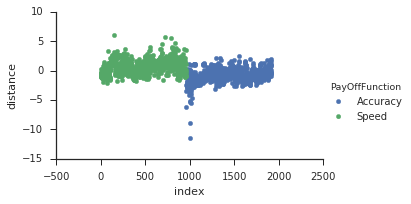

In [10]:
from sklearn.utils import shuffle
from  matplotlib import pyplot

import seaborn
seaborn.set(style='ticks')


# Set the parameters by cross-validation

augmented_dataset = cross_validate( train_model, 'PayOffFunction', ['TrialNumber'])

augmented_dataset.head(5).columns

augmented_dataset.to_csv('result.csv')

#index in the initial dataset
augmented_dataset['index'] = augmented_dataset.index

fg = seaborn.FacetGrid(data=augmented_dataset, hue='PayOffFunction', aspect=1.61)
fg.map(pyplot.scatter, 'index', output_dist).add_legend()
plt.show()